In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.functional as F

from IPython.display import clear_output

from tictactoe import TicTacToe

In [2]:
def b9tob27(b9):
    b9 = b9.reshape([-1, 9])
    b27 = np.zeros([b9.shape[0], 9, 3])
    b27[b9 == 0, 0] = 1
    b27[b9 == 1, 1] = 1
    b27[b9 == -1, 2] = 1
    return b27.reshape([-1, 27])
    
class DQN(nn.Module): # Q(s)
    def __init__(self, n_input=3*3*3, n_output=3*3, n_hidden=81):
        super().__init__()
        self._fc1 = nn.Linear(n_input, n_hidden)
        self._fc2 = nn.Linear(n_hidden, n_output)
        self._sigmoid = nn.Sigmoid()
        
    def forward(self, board):
        board = torch.from_numpy(b9tob27(board)).float()
        x = self._fc1(board)
        y = self._fc2(self._sigmoid(x))
        return y
    
    def choose_action(self, board, mode='best', epsilon=0.2): # 不能批量处理
        board = board.flatten()
        if board.shape[0] != 9:
            print('只能处理一个棋盘。')
            return None
        
        ac_idx = np.where(board == 0)[0]
        if ac_idx.shape[0] == 0:
            print('已无法下子。')
            return None
        
        q = self.forward(board).detach().numpy()[0][ac_idx]
        
        if mode == 'best':
            idx = np.argmax(q)
            return ac_idx[idx]
        if mode == 'advn':
            if np.random.random() > epsilon:
                idx = np.argmax(q)
                return ac_idx[idx]
            else:
                idx = np.random.choice(ac_idx.shape[0])
                return ac_idx[idx]
        return None
    
def learn(memory, batch_size=64, epochs=1):
    loss_list = []
    for epoch in range(epochs):
        sample_range = min(memory_pointer, memory_size)
        batch_index = np.random.choice(sample_range, 
                                       size=batch_size, 
                                       replace=False, 
                                       p=weight[:sample_range]/weight[:sample_range].sum())
        batch_sample = memory[batch_index]
        
        board_list = batch_sample[:, :9]     # [bs, 9]
        turn_list = batch_sample[:, 9:10]    # [bs, 1]
        action_list = batch_sample[:, 10]    # [bs,]
        reward_list = batch_sample[:, 11:12] # [bs, 1]
        done_list = batch_sample[:, 12:13]   # [bs, 1]
        _board_list = batch_sample[:, 13:]   # [bs, 9]

        q = actor(board_list * turn_list)    # [bs, 9]
        _q = q.clone().detach()              # [bs, 9]
        for i in range(batch_size):
            if done_list[i]:
                _q[i, int(action_list[i])] = torch.from_numpy(reward_list[i] * turn_list[i])
            else:
                # double dqn
                action = actor.choose_action(_board_list[i] * -turn_list[i], mode='best')
                _q[i, int(action_list[i])] = actor_target(_board_list[i] * -turn_list[i])[0, action] * -1 * gamma
        
        loss = mseloss(q, _q)
        optim.zero_grad()
        loss.backward()
        optim.step()
        weight[batch_index] = loss.item()
        loss_list.append(loss.item())
    return loss_list

In [3]:
lr = 0.001
gamma = 0.99
actor = DQN()
actor_target = DQN()
actor_target.load_state_dict(actor.state_dict())
optim = torch.optim.Adam(actor.parameters(), lr=lr)
mseloss = torch.nn.MSELoss()

ttt = TicTacToe()

epsilon = 1
epsilon_delay = 0.9999
epsilon_min = 0.2

n_feature = 9 + 1 + 1 + 1 + 1 + 9 # board, turn, action, win, done, next_board
memory_size = 50000
memory_pointer = 0
memory = np.zeros([memory_size, n_feature])
weight = np.ones([memory_size,]) #####

In [7]:
actor.load_state_dict(torch.load('model/tictactoe_ddqn.pkl'))
actor_target.load_state_dict(torch.load('model/tictactoe_ddqn.pkl'))

<All keys matched successfully>

经过100轮，玩家一战绩为28-10-62。
经过200轮，玩家一战绩为25-9-66。
经过300轮，玩家一战绩为32-13-55。
经过400轮，玩家一战绩为25-10-65。
经过500轮，玩家一战绩为33-15-52。
经过600轮，玩家一战绩为2-72-26。
经过700轮，玩家一战绩为2-66-32。
经过800轮，玩家一战绩为8-59-33。
经过900轮，玩家一战绩为15-44-41。
经过1000轮，玩家一战绩为24-39-37。
经过1100轮，玩家一战绩为31-23-46。
经过1200轮，玩家一战绩为34-11-55。
经过1300轮，玩家一战绩为37-19-44。
经过1400轮，玩家一战绩为30-22-48。
经过1500轮，玩家一战绩为25-22-53。
经过1600轮，玩家一战绩为5-61-34。
经过1700轮，玩家一战绩为3-76-21。
经过1800轮，玩家一战绩为4-68-28。
经过1900轮，玩家一战绩为3-65-32。
经过2000轮，玩家一战绩为0-71-29。
经过2100轮，玩家一战绩为0-66-34。
经过2200轮，玩家一战绩为1-68-31。
经过2300轮，玩家一战绩为1-64-35。
经过2400轮，玩家一战绩为0-74-26。
经过2500轮，玩家一战绩为0-69-31。
经过2600轮，玩家一战绩为1-73-26。
经过2700轮，玩家一战绩为0-65-35。
经过2800轮，玩家一战绩为1-62-37。
经过2900轮，玩家一战绩为1-62-37。
经过3000轮，玩家一战绩为1-69-30。
经过3100轮，玩家一战绩为0-68-32。
经过3200轮，玩家一战绩为0-71-29。
经过3300轮，玩家一战绩为0-80-20。
经过3400轮，玩家一战绩为0-71-29。
经过3500轮，玩家一战绩为0-62-38。
经过3600轮，玩家一战绩为0-66-34。
经过3700轮，玩家一战绩为0-71-29。
经过3800轮，玩家一战绩为0-67-33。
经过3900轮，玩家一战绩为0-72-28。
经过4000轮，玩家一战绩为0-68-32。
经过4100轮，玩家一战绩为0-64-36。
经过4200轮，玩家一战绩为0-66-34。
经过4300轮，玩家一战绩为0-75-25。
经过4400轮，玩

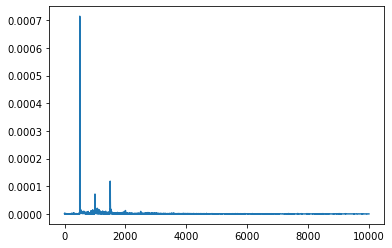

In [9]:
history = []
total_round = 10000
win_round = 0
draw_round = 0
for cur_round in range(total_round):
    board, turn, win, done = ttt.reset(np.random.choice([1, -1], 1)[0])
    while not done:
        if turn == 1:
            action = actor.choose_action(board, mode='advn', epsilon=0.2)
        elif turn == -1:
            action = actor.choose_action(-board, mode='best')
        _board, _turn, win, done = ttt.step(action)
        memory[memory_pointer % memory_size] = np.concatenate((board, [turn], [action], [win], [done], _board))
        weight[memory_pointer % memory_size] = 0.001 #####
        memory_pointer += 1
        
        board = _board
        turn = _turn
    
    if memory_pointer > 500:
        loss_list = learn(memory, 128, 3)
        history.append(np.mean(np.square(loss_list)))
        
    epsilon = max(epsilon * epsilon_delay, epsilon_min)
    
    if win == 1:
        win_round += 1
    elif win == 0:
        draw_round += 1
    if (cur_round + 1) % 100 == 0:
        print('经过%d轮，玩家一战绩为%d-%d-%d。' % (cur_round + 1, win_round, draw_round, 100-win_round-draw_round))
        win_round = 0
        draw_round = 0
    
    if (cur_round + 1) % 500 == 0:
        actor_target.load_state_dict(actor.state_dict())

plt.plot(history)
plt.show()

In [11]:
# torch.save(actor.state_dict(), 'model/tictactoe_ddqn.pkl.pkl')

## Q值查看

In [18]:
board = np.array([1, -1, 1, -1, 1, -1, -1, 0, 0])
turn = 1
win = 0
ttt.board = board
ttt.turn = 1
ttt.win = 0

q = actor(board)[0]
print(q)
    
ttt.draw_board()

tensor([ 0.2240,  0.7302, -0.3951, -0.0469,  0.5450, -0.9213,  1.1070, -0.2396,
         1.0995], grad_fn=<SelectBackward0>)
o|x|o  o
x|o|x
x|7|8


## 最终测试 - 只有随机玩家不胜才成功。

In [13]:
record = [] # 将输给随机玩家的棋谱记录下来。

# actor.load_state_dict(torch.load('model/tictactoe_ddqn.pkl.pkl'))

total_round = 10000
win_round = 0
draw_round = 0

epsilon = 0.5
epsilon_delay = 0.9999
epsilon_min = 0.1

for cur_round in range(total_round):
    board, turn, win, done = ttt.reset(np.random.choice([1, -1], 1)[0])
    action_list = []
    while not done:
        if turn == 1:
            action = actor.choose_action(board, mode='advn', epsilon=epsilon)
        elif turn == -1:
            action = actor.choose_action(-board, mode='best')
        _board, _turn, win, done = ttt.step(action)
        
        board = _board
        turn = _turn
        
        action_list.append(action.item())
        
    epsilon = max(epsilon * epsilon_delay, epsilon_min)
    
    if win == 1:
        win_round += 1
        record.append(action_list)
    elif win == 0:
        draw_round += 1
    print('\r正在进行第%d轮游戏。。' % (cur_round+1), end='', flush=True)
print('随机玩家战绩为%d-%d-%d。' % (win_round, draw_round, total_round-win_round-draw_round))

正在进行第10000轮游戏。。随机玩家战绩为0-6117-3883。


## 玩家试玩

In [4]:
ttt = TicTacToe()
actor = DQN()
actor.load_state_dict(torch.load('model/tictactoe_ddqn.pkl.pkl'))
board, turn, win, done = ttt.reset(np.random.choice([1, -1], 1)[0])
while not done:
    if turn == 1:
        action = actor.choose_action(board, mode='best', epsilon=0.2)
    elif turn == -1:
        ttt.draw_board()
        action = int(input())
        clear_output()
        
    board, turn, win, done = ttt.step(action)
    
ttt.draw_board()
if win == 1:
    print('电脑获胜！')
elif win == -1:
    print('玩家获胜！')
else:
    print('平局！')
    

x|o|o  o
o|x|x
x|x|o
平局！
